In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')
import statsmodels.api as sm

 Data taken by hand from [Secretaria de Salud](https://www.gob.mx/salud/documentos/informacion-internacional-y-nacional-sobre-nuevo-coronavirus-2019-ncov). We take daily data on the number of confirmed cases. 

In [0]:
date = ['2020-02-28','2020-02-29','2020-03-01','2020-03-02','2020-03-03','2020-03-04'
       ,'2020-03-05','2020-03-06','2020-03-07','2020-03-08','2020-03-09','2020-03-10',
       '2020-03-11','2020-03-12','2020-03-13','2020-03-14','2020-03-15','2020-03-16',
       '2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-21','2020-03-22',
        '2020-03-23','2020-03-24','2020-03-25','2020-03-26','2020-03-27','2020-03-28']

confirmed_cases = [3,4,5,5,5,5,5,6,7,7,7,7,11,14,26,41,53,82,93,118,164,203,251,316
                   ,367,405,475,585,717,848]

df = pd.DataFrame({'date':date,'confirmed_cases':confirmed_cases})
df['date']=pd.to_datetime(df['date'])

days_since_first_case = []
for i in df.index:
    days_since_first_case.append(i)
    
df['days_since_first_case'] = days_since_first_case
df['log_confirmed_cases'] = np.log(df['confirmed_cases'])
df['rel_diff'] = df['confirmed_cases']/df['confirmed_cases'].shift(1) - 1

In [5]:
df.head()

,date,confirmed_cases,days_since_first_case,log_confirmed_cases,rel_diff
0,2020-02-28,3,0,1.098612,NaN
1,2020-02-29,4,1,1.386294,0.333333
2,2020-03-01,5,2,1.609438,0.250000
3,2020-03-02,5,3,1.609438,0.000000
4,2020-03-03,5,4,1.609438,0.000000


To obtain information about the developement of the number of confirmed cases and to perform an OLS regression, we define function 'covid_mx'. The inputs are the days used for regression and the confidence interval.

In [0]:
def covid_mx(days_of_regression, confidence_interval = 0.95):

  days_back = days_of_regression
  current_day = df['days_since_first_case'].iloc[-1]
  next_day = df['days_since_first_case'].iloc[-1] +1
  alpha = 1 - confidence_interval
  exp_start_date = '2020-03-10' # The day of the begining of exponential growth (apprx.)
  exp_start_index = df[df['date'] == exp_start_date].index[0] # The corresponiding index

  
  # The model:

  X = df['days_since_first_case'][-days_back:]
  y = df['log_confirmed_cases'][-days_back:]
  X = sm.add_constant(X)
  model = sm.OLS(y, X).fit()

  # Predictions

  df['predicted'] = model.get_prediction(X).summary_frame(alpha = 0.05)['mean']
  df['pred_lb'] = model.get_prediction(X).summary_frame(alpha = 0.05)['obs_ci_lower']
  df['pred_ub'] = model.get_prediction(X).summary_frame(alpha = 0.05)['obs_ci_upper']
  df['conf_lb'] = model.get_prediction(X).summary_frame(alpha = 0.05)['mean_ci_lower']
  df['conf_ub'] = model.get_prediction(X).summary_frame(alpha = 0.05)['mean_ci_upper']

  df['real_pred'] = np.exp(df['predicted'])
  df['square_diff'] = (df['confirmed_cases']-df['real_pred'])**2
  df['resid'] = model.resid
  df['resid_real'] = df['confirmed_cases']-df['real_pred']

  prediction_next_day = np.exp(model.get_prediction([1,next_day]).summary_frame(alpha = 0.05)['mean'])[0] # prediction tomorrow
  lb_next_day = np.exp(model.get_prediction([1,next_day]).summary_frame(alpha = 0.05)['obs_ci_lower'])[0] 
  ub_next_day = np.exp(model.get_prediction([1,next_day]).summary_frame(alpha = 0.05)['obs_ci_upper'])[0] 
  ci_lb = np.exp(model.get_prediction([1,next_day]).summary_frame(alpha = 0.05)['mean_ci_lower'])[0]
  ci_ub = np.exp(model.get_prediction([1,next_day]).summary_frame(alpha = 0.05)['mean_ci_upper'])[0]  

  ## OUTPUTS
  
  # Basic info

  print(20*'====')
  print('Covid-19 in Mexico')
  print(20*'====')

  print('Current Day:', current_day)
  print('Days used for regression: ',days_back)
  print('Confidence interval: ', confidence_interval * 100,'%')
  
  print(20*'====')
  print(20*'====')


  print('Predicted number of cases for day {}: '.format(next_day),round(np.exp(model.params[0]+model.params[1]*next_day),2))
  print('Prediction interval lower and upper bounds: ({},{})'.format(round(lb_next_day,2),round(ub_next_day,2)))
  print('Confidence Interval Lower and Upper bounds: ({},{})'.format(round(ci_lb,2),round(ci_ub,2)))
  print('R^2: ',round(model.rsquared,4))
  print('MSE :',  round(((df['square_diff'].sum())**0.5)/days_back,4))

  print(30*'====')
  print('Historical Developement')
  print(30*'====')

  plt.figure(figsize=(10,5))
  sns.lineplot(x = 'date',y = 'confirmed_cases',data = df,marker="o")
  plt.title('Number of Confirmed Cases')
  plt.axvline(x='2020-03-10',color = 'red',ls = '--',label = 'Begining Exponential Phase',alpha = 0.5,linewidth=2.0)
  plt.xlabel('Date')
  plt.ylabel('Confirmed Cases')
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

  print(30*'====')

  plt.figure(figsize=(10,5))
  sns.lineplot(x = 'date',y = 'log_confirmed_cases',data = df,marker="o",label = 'Begining Exponential Phase')
  plt.axvline(x='2020-03-10',color = 'red',ls = '--',alpha = 0.5,linewidth=2.0)
  plt.title('Number of Confirmed Cases (Log)')
  plt.xlabel('Date')
  plt.ylabel('Confirmed Cases (Log)')
  plt.xticks(rotation=45)
  plt.show()  

  print(30*'====')
  print('Mean relative change in number of confirmed cases: ',round(df['rel_diff'][-19:].mean(),4))
  print(30*'====')

  plt.figure(figsize=(10,5))
  plt.plot(df['date'][exp_start_index:],df['rel_diff'][-19:],marker='o')
  plt.axhline(df['rel_diff'][-19:].mean(),color = 'red',ls = '--',label = 'Mean',alpha = 0.5,linewidth=2.0)
  plt.title('Relative change in number of confirmed cases (since exp. phase)')
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

  print(30*'====')

  plt.figure(figsize=(10,5))
  df['rel_diff'][exp_start_index:].hist(bins=22)
  plt.axvline(df['rel_diff'][-19:].mean(),color = 'red',ls = '--',label = 'Mean',alpha = 0.5,linewidth=2.0)
  plt.title('Distribution of relative change in number of confirmed cases (since exp. phase)')
  plt.xticks(rotation=45)
  plt.legend()
  plt.show()

  print(30*'====')
  print('Regression Plots')
  print(30*'====')

  # Regression plots

  plt.figure(figsize=(15,5))
  plt.plot(df['date'][-days_back:],df['predicted'][-days_back:],'-',c='r',label = 'regression',linewidth=2.0)
  plt.plot(df['date'][-days_back:],df['log_confirmed_cases'][-days_back:],'o')
  plt.plot(df['date'][-days_back:],df['pred_lb'][-days_back:],c='r',ls = '--',alpha = 0.5,linewidth=2.0,label = 'pred. interval')
  plt.plot(df['date'][-days_back:],df['pred_ub'][-days_back:],c='r',ls = '--',alpha = 0.5,linewidth=2.0)
  plt.plot(df['date'][-days_back:],df['conf_lb'][-days_back:],c='g',ls = '--',alpha = 0.5,linewidth=2.0,label = 'conf. interval')
  plt.plot(df['date'][-days_back:],df['conf_ub'][-days_back:],c='g',ls = '--',alpha = 0.5,linewidth=2.0)
  plt.legend()
  plt.xticks(rotation=45)
  plt.show()

  print(30*'====')

  plt.figure(figsize=(15,5))
  plt.plot(df['date'][-days_back:],np.exp(df['predicted'][-days_back:]),'-',c='r',label = 'regression',linewidth=2.0)
  plt.plot(df['date'][-days_back:],np.exp(df['log_confirmed_cases'][-days_back:]),'o')
  plt.plot(df['date'][-days_back:],np.exp(df['pred_lb'][-days_back:]),c='r',ls = '--',alpha = 0.5,linewidth=2.0,label = 'pred. interval')
  plt.plot(df['date'][-days_back:],np.exp(df['pred_ub'][-days_back:]),c='r',ls = '--',alpha = 0.5,linewidth=2.0)
  plt.plot(df['date'][-days_back:],np.exp(df['conf_lb'][-days_back:]),c='g',ls = '--',alpha = 0.5,linewidth=2.0,label = 'conf. interval')
  plt.plot(df['date'][-days_back:],np.exp(df['conf_ub'][-days_back:]),c='g',ls = '--',alpha = 0.5,linewidth=2.0)
  plt.legend()
  plt.xticks(rotation=45)
  plt.show()

  print(30*'====')

  plt.figure(figsize=(10,5))
  sns.scatterplot(x = 'real_pred',y = 'resid_real',data = df)
  plt.axhline(0,c = 'b')
  plt.title('Pred. vs. Resid.')
  plt.xticks(rotation=45)
  plt.show()

  

  print(30*'====')
  print('Regression Details')
  print(30*'====')

  print(model.summary())



/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Covid-19 in Mexico
Current Day: 29
Days used for regression:  10
Confidence interval:  95.0 %
Predicted number of cases for day 30:  1010.35
Prediction interval lower and upper bounds: (896.33,1138.86)
Confidence Interval Lower and Upper bounds: (944.36,1080.94)
R^2:  0.9943
MSE : 4.2049
Historical Developement


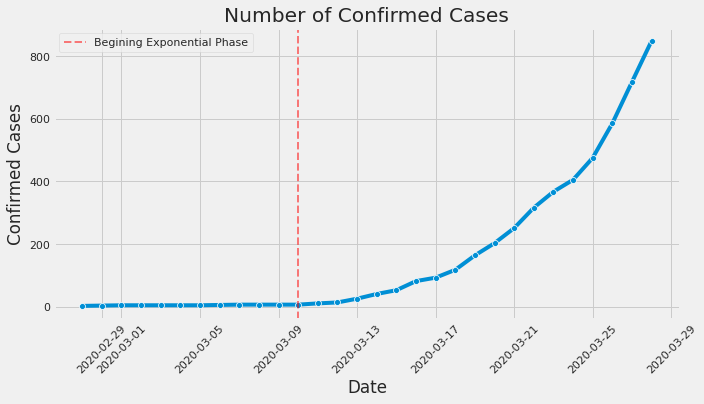

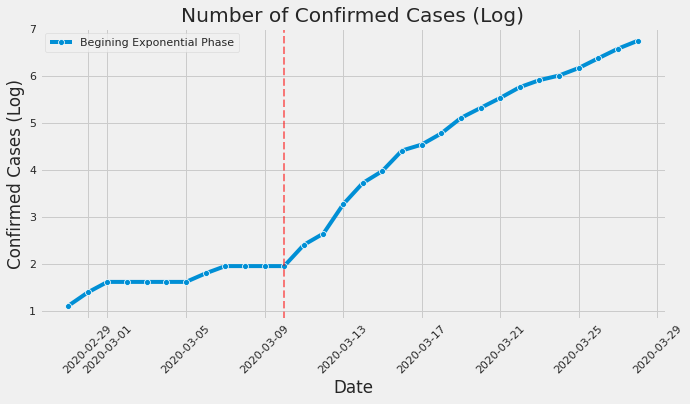

Mean relative change in number of confirmed cases:  0.3011


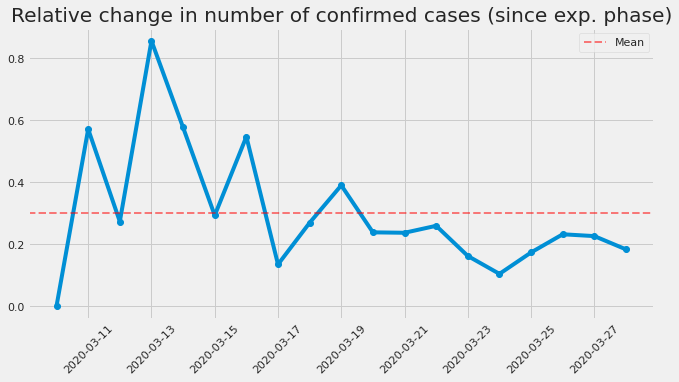

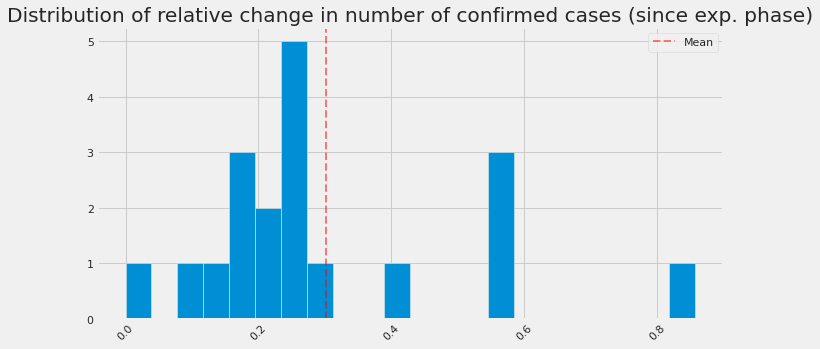

Regression Plots


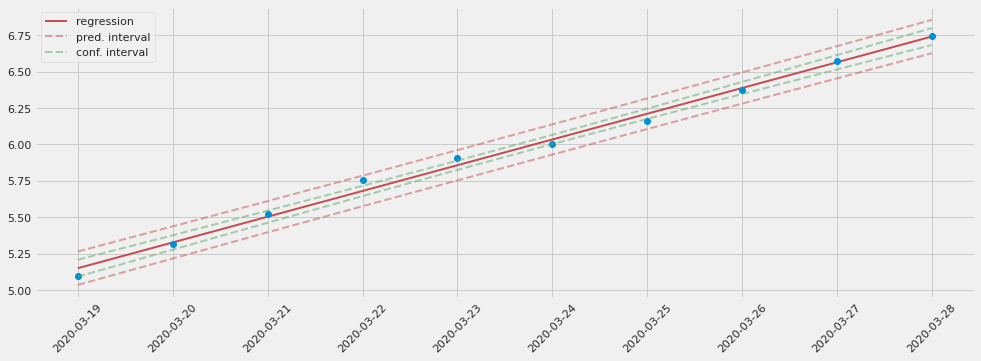

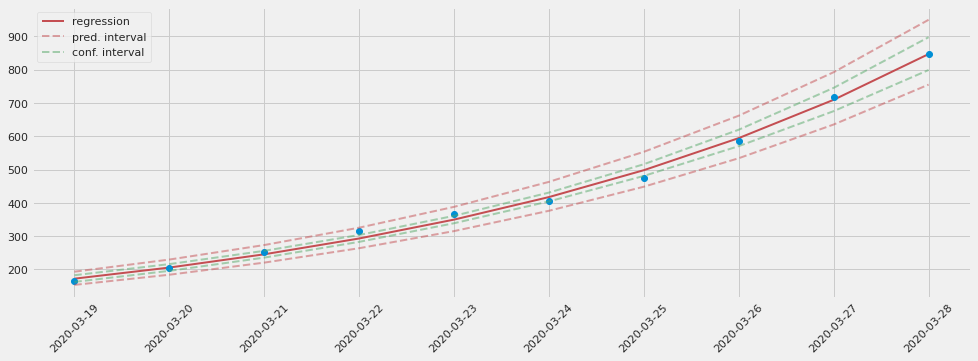

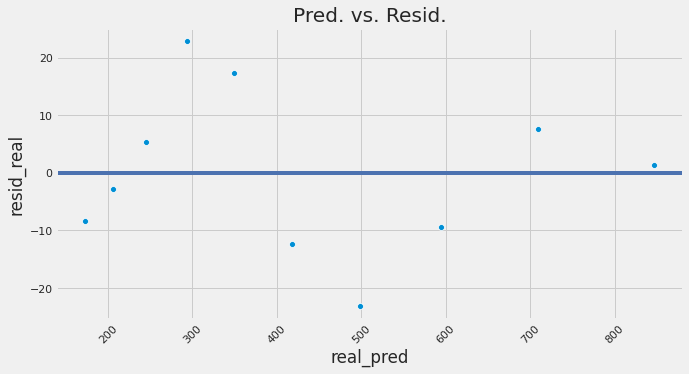

Regression Details
                             OLS Regression Results                            
Dep. Variable:     log_confirmed_cases   R-squared:                       0.994
Model:                             OLS   Adj. R-squared:                  0.994
Method:                  Least Squares   F-statistic:                     1403.
Date:                 Mon, 30 Mar 2020   Prob (F-statistic):           2.83e-10
Time:                         23:05:34   Log-Likelihood:                 18.421
No. Observations:                   10   AIC:                            -32.84
Df Residuals:                        8   BIC:                            -32.24
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
c

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [7]:
covid_mx(10)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


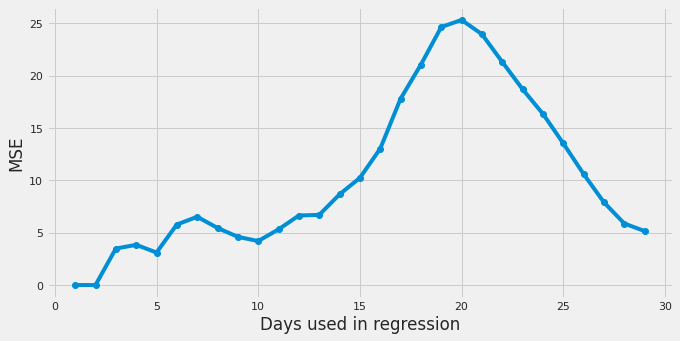

In [8]:
day_back_list = []
MSE_REAL_list = []

for days_back in range(1,len(df)):
    
    X = df['days_since_first_case'][-days_back:]
    y = df['log_confirmed_cases'][-days_back:]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X) 
    
    df['predicted'] =  predictions
    df['real_pred'] = np.exp(df['predicted'])
    df['square_diff'] = (df['confirmed_cases']-df['real_pred'])**2
    MSE_REAL = ((df['square_diff'].sum())**0.5)/days_back
    
    day_back_list.append(days_back)
    MSE_REAL_list.append(MSE_REAL)
    
MSE_df =pd.DataFrame({'days_back':day_back_list,'MSE_REAL':MSE_REAL_list})    

plt.figure(figsize=(10,5))
plt.plot(MSE_df['days_back'],MSE_df['MSE_REAL'],marker='o')
plt.xlabel('Days used in regression')
plt.ylabel('MSE')
plt.show()